### Binary Signal Detection

Sets representing a finite number of indexed objects/states or relationships (symbols)

$
		{\textrm{Tx: } \{p(a_n)\}: {\bm{a}} }\longrightarrow {\textrm{Cx: }y = {\bm{a}} +\eta :\mathcal{N}_{\eta}(0,\sigma_{\eta}) }\longrightarrow {\textrm{Rx: } \textrm{compare: }\operatorname{M}({\bm{a}},\bm{\hat{a}})\Rightarrow\{p(y|a_n)\}}
		$

In [ ]:
import numpy as np
import math

from scipy import signal
from scipy.signal import lti 
from scipy.integrate import quad
import scipy.stats
from scipy.fft import fft , fftfreq ,fftshift

import matplotlib.pyplot as plt  # data plotting 
from matplotlib import rcParams

rcParams['figure.figsize']     = [15,6] 
rcParams['lines.markersize']   = 9         # marker size in points
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.dpi']     = 180

from matplotlib import colors
from ipywidgets import interact

Histogram computation

In [ ]:
def coloredhist(X,plot):
    Nbins = int(1 + 3.322*np.log2(len(X)))
    n, bins, patches = ax[1].hist(X, bins = Nbins )
    fracs = n / n.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    ax[1].hist(X, bins=Nbins,weights=weight, density=True) 
    plt.grid()
    return

In [ ]:
# Normal pdf 
def normal_distribution_function_r(x):
    value = scipy.stats.norm.pdf(x, mean, std)
    return value

def normal_distribution_function_l(x):
    value = scipy.stats.norm.pdf(x, -mean, std)
    return value

In [ ]:
def norMaxMin(data):
    min_value = np.min(data)
    max_value = np.max(data)
    return (data - min_value) / (max_value - min_value)

In [ ]:
import os

def clearConsole():
    command = 'clear'
    if os.name in ('nt', 'dos'):  # If Machine is running on Windows, use cls
        command = 'cls'
    os.system(command)

#### Tx
message = $\{a_n{\in }\mathbb{R}:n {\in} N\}$ --  {alphabet}

$\{p_i\in\mathbb{R}[0,1]\}$

In [ ]:
clearConsole()

#Symbol Data Generation
    # symbol values {a0, a1}
a1 = 1       # symbol a1
a0 = -1      # symbol a0
Nsamples = 2048  # time samples per symbol
    # symbol probability
p_0 = 0.25;   p_1 = 1 - p_0

    # symbol set
Nsymbols = 128
                # sample set
N = Nsymbols*Nsamples 
data    = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
data    = np.concatenate([[v]*Nsamples for v in data])
message = data


#### Cx
Channel simulation: Additive White Gaussian Noise: $\eta(t),$ with $\mathbb{E}\{\eta(t)\}=0$

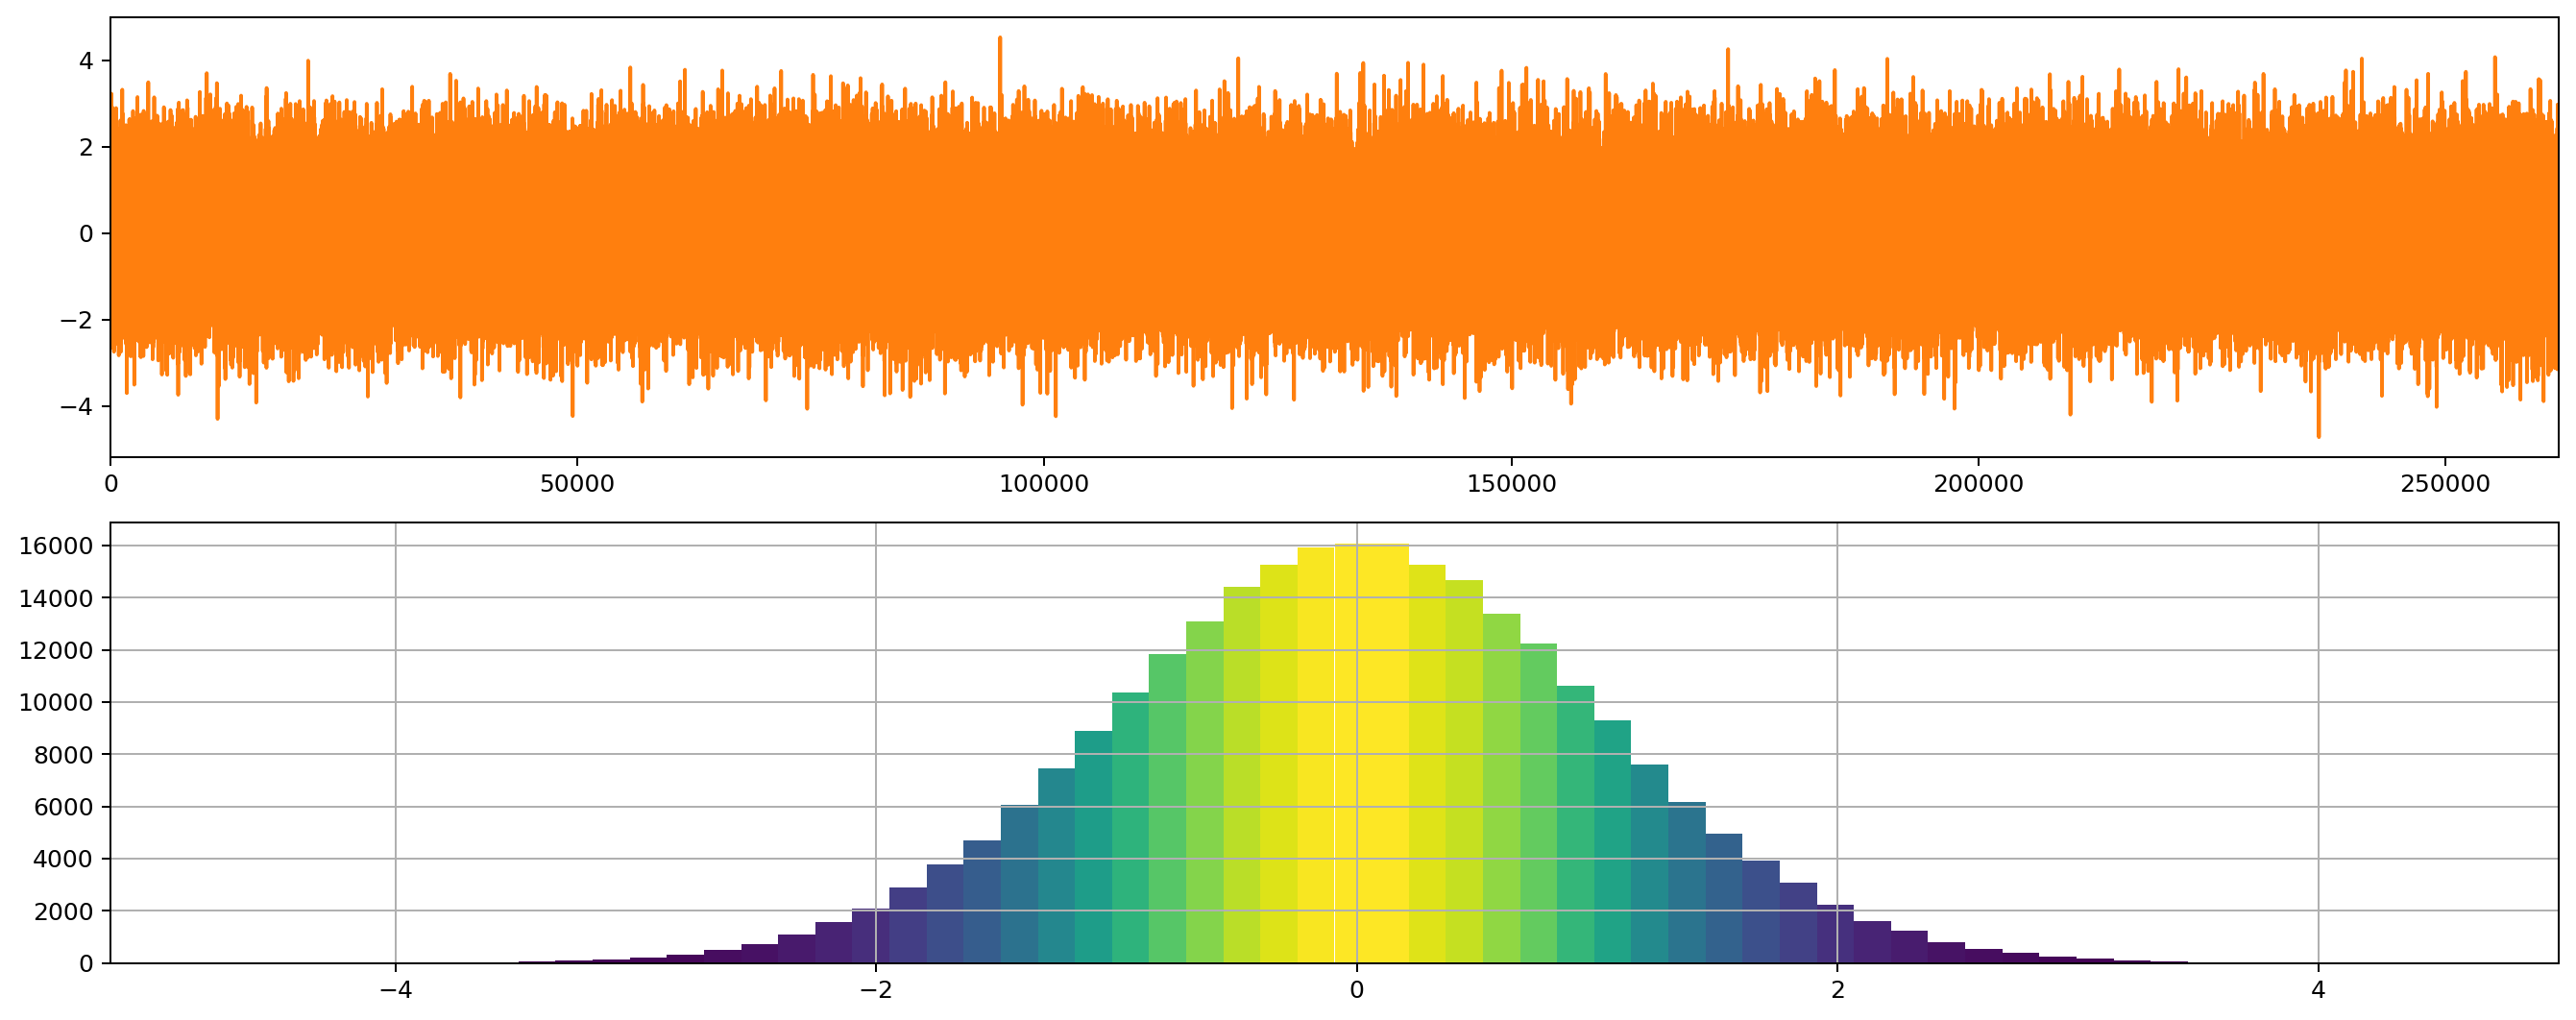

In [ ]:
time = np.linspace(0,N,N)
Nbins = int(1 + 3.322*np.log2(len(data)))
weight = np.ones_like(message)/N

fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time,message, '-') 
ax[0].set_xlim(0,len(message))

# Zero-mean Gaussian noise
σ2 = 1 # Noise variance
noise = np.random.normal(0, σ2, N)
ax[0].plot(time,noise)
ax[1].hist(message, bins=Nbins,  density=True)
coloredhist(noise,plot=1)

Additive Gaussian Channel
$y(t) = \sum_{\forall k}{{a}_n}\operatorname{rect}_{\delta t}(t-k\delta t) +\eta(t)$

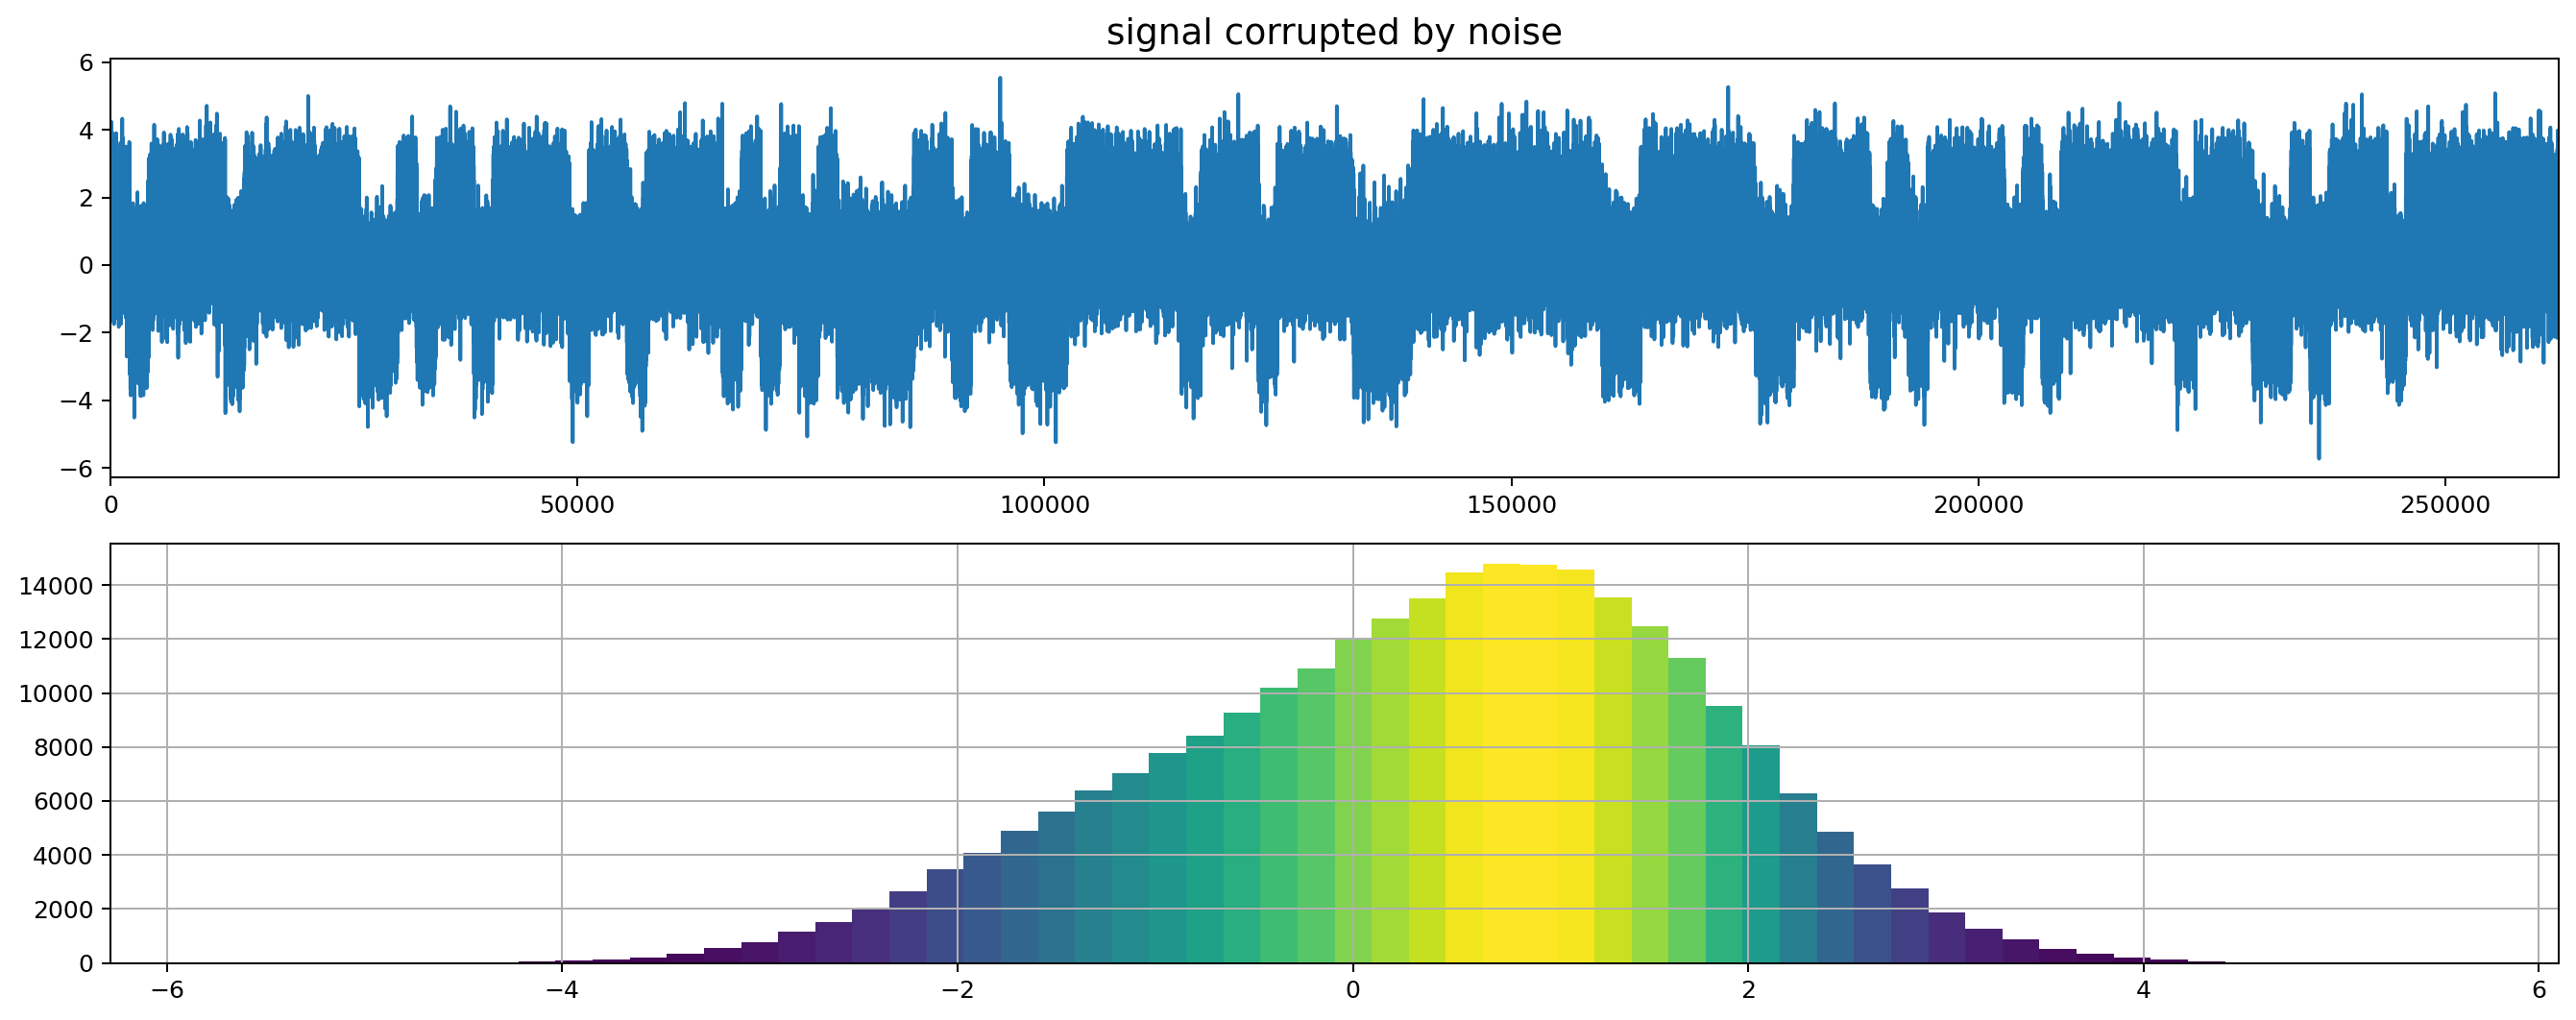

In [ ]:
y =  message + noise # corrupted signal
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time,y, '-') 
ax[0].set_title('signal corrupted by noise')
ax[0].set_xlim(0,N)
coloredhist(y,plot=1)
#ax[1].hist(message+noise, bins=Nbins,  density=True)
plt.show()

#### Rx 
smoothing by a RC low-band pass filter

In [ ]:
# smoothing filter parameters
R = 3000
C = .0003 
num = [1]
den = [R*C, 1]

# filter response
lti_system = lti(num, den)
t, h = lti_system.impulse(N)  
coeff = fftshift(fft(h))
# transfer function
f = fftshift(fftfreq(coeff.shape[0],t[1]-t[0]))

/tmp/ipykernel_94/1975022187.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot(grid[0, 0])
/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


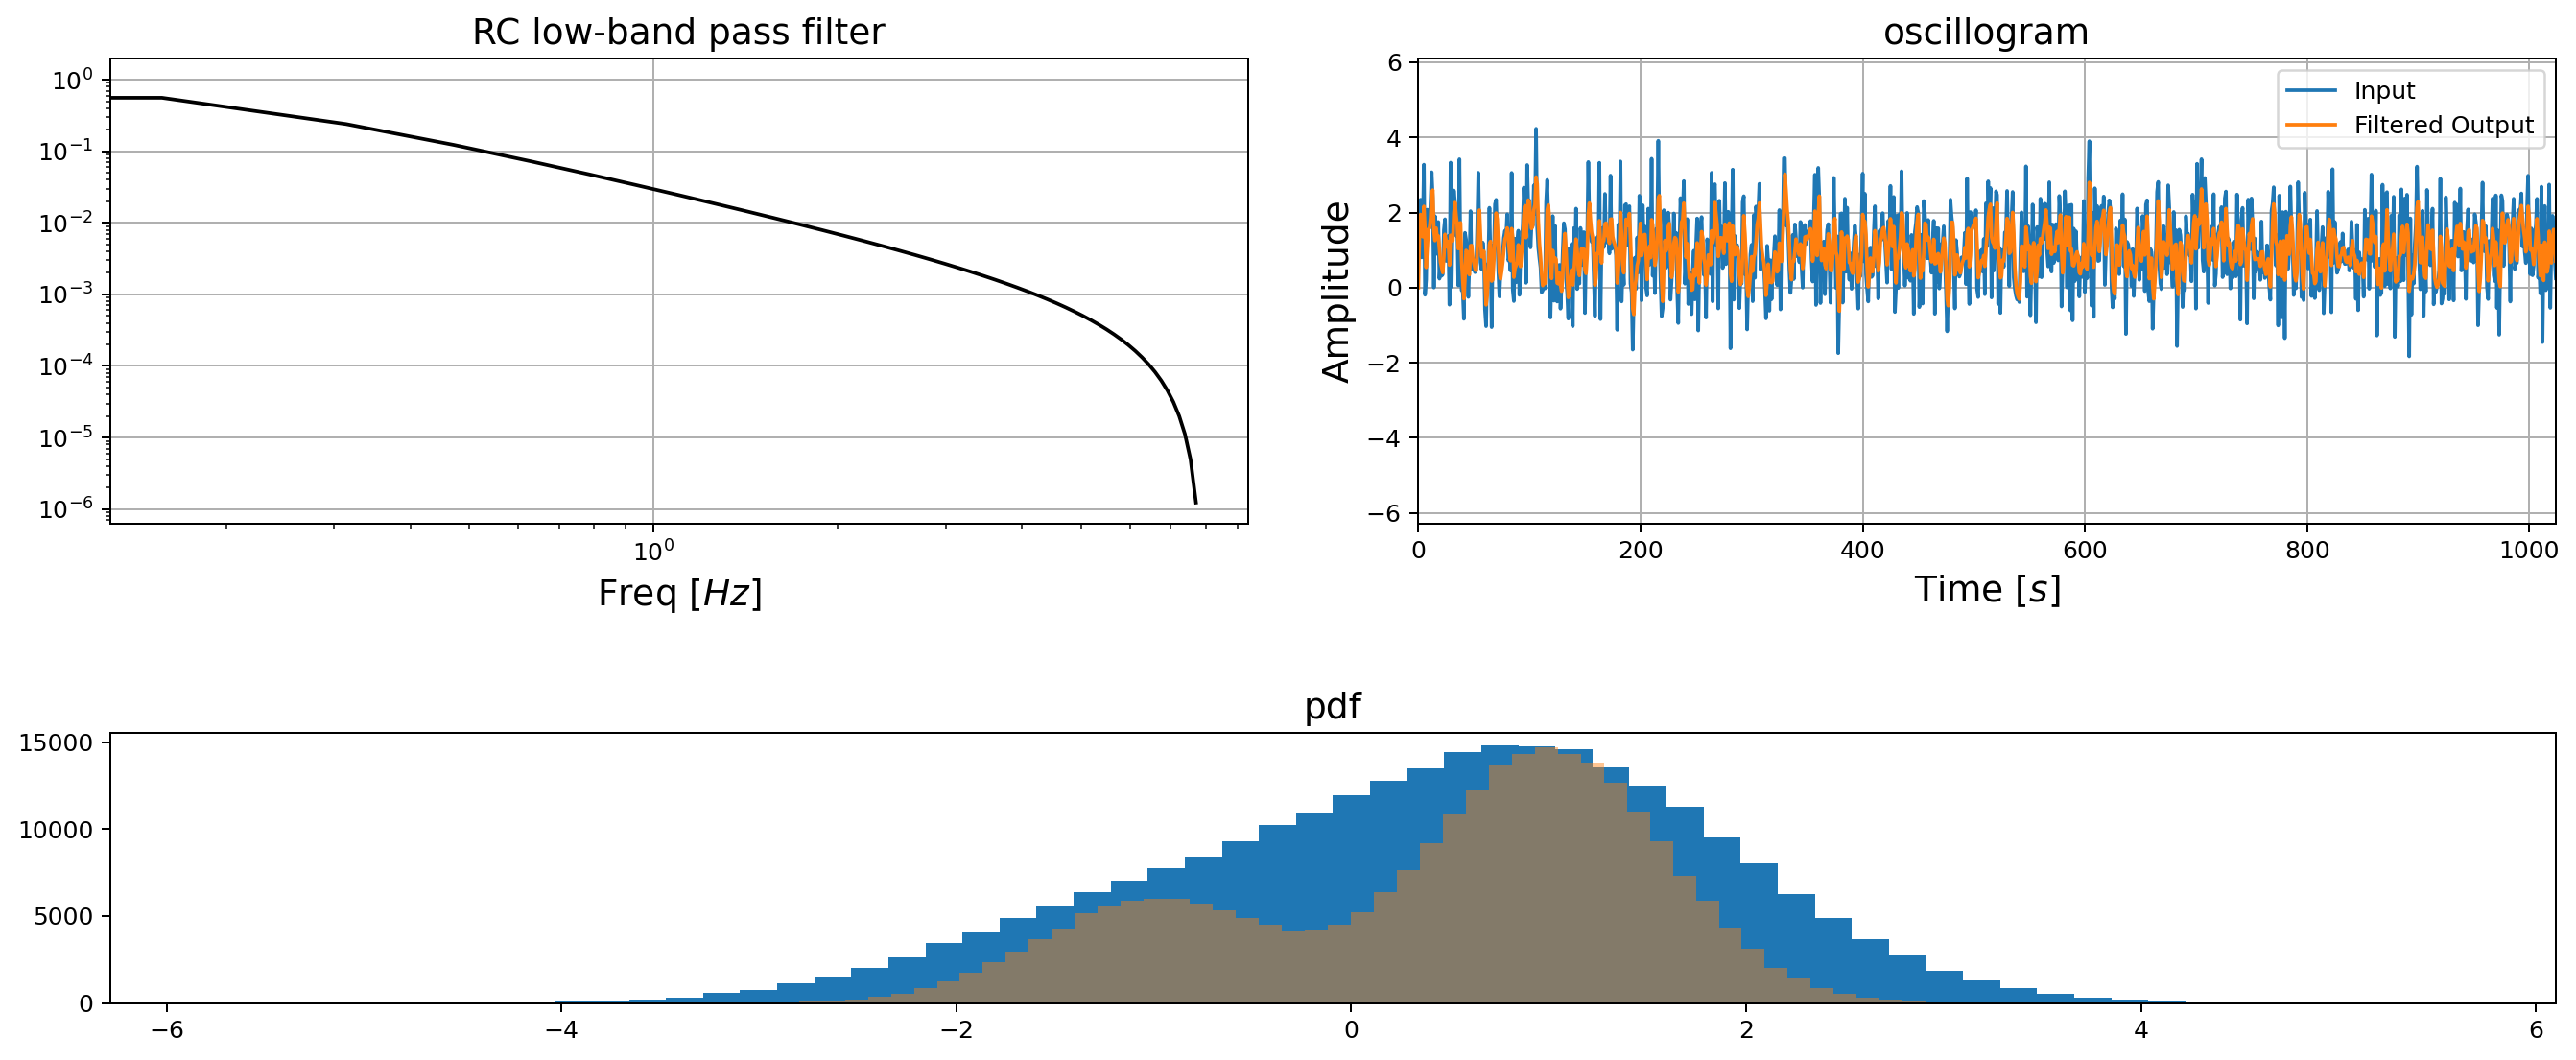

In [ ]:
fig, ax = plt.subplots(3, 1, tight_layout=True)

grid = plt.GridSpec(2, 2, wspace=0.15, hspace=0.03)
ax[0] = plt.subplot(grid[0, 0])
ax[0].set_title('RC low-band pass filter')
ax[0].loglog(f,norMaxMin(coeff),'k')
ax[0].set_xlabel('Freq [$Hz$]')
ax[0].grid()

ax[1] = plt.subplot(grid[0, 1])
_,output0_,_ = lti_system.output(y, time)
ax[1].plot(time, y, label='Input')
ax[1].plot(time, output0_, label='Filtered Output')
ax[1].set_title('oscillogram')
ax[1].set_xlim(0,Nsamples/2)
ax[1].grid(True)
ax[1].set_xlabel('Time [$s$]')
ax[1].set_ylabel('Amplitude')

ax[2].set_title('pdf')
ax[2].hist(y, bins = Nbins, label='Input')
_,y,_ =ax[2].hist(output0_, bins = Nbins, label='Output',alpha=.45)
plt.legend()
plt.show()

$\varLambda (y)=  {{p(y|a_1 )}}/{{p(y|a_0 )}} \textrm{   Likelihood ratio}$

In [ ]:
umbral = y.copy()
error = []
mean = a1 ; std = np.sqrt(σ2)
for u in umbral: 
# --------------------- P(a1/a0) -----------------------#
    αinf = mean - 6 *std 
    res0, err = quad(normal_distribution_function_l, αinf, u)

# --------------------- P(a0/a1) -----------------------# 
    mean = a0
    αinf = a1 + 6 * std 
    res1, err = quad(normal_distribution_function_r, u, αinf)
        
    error.append(p_0*res0 + p_1*res1)

In [ ]:
y1 = scipy.stats.norm.pdf(y,a1,std);  y1 = y1*p_1
y0 = scipy.stats.norm.pdf(y,a0,std);  y0 = y0*p_0

Threshold computation

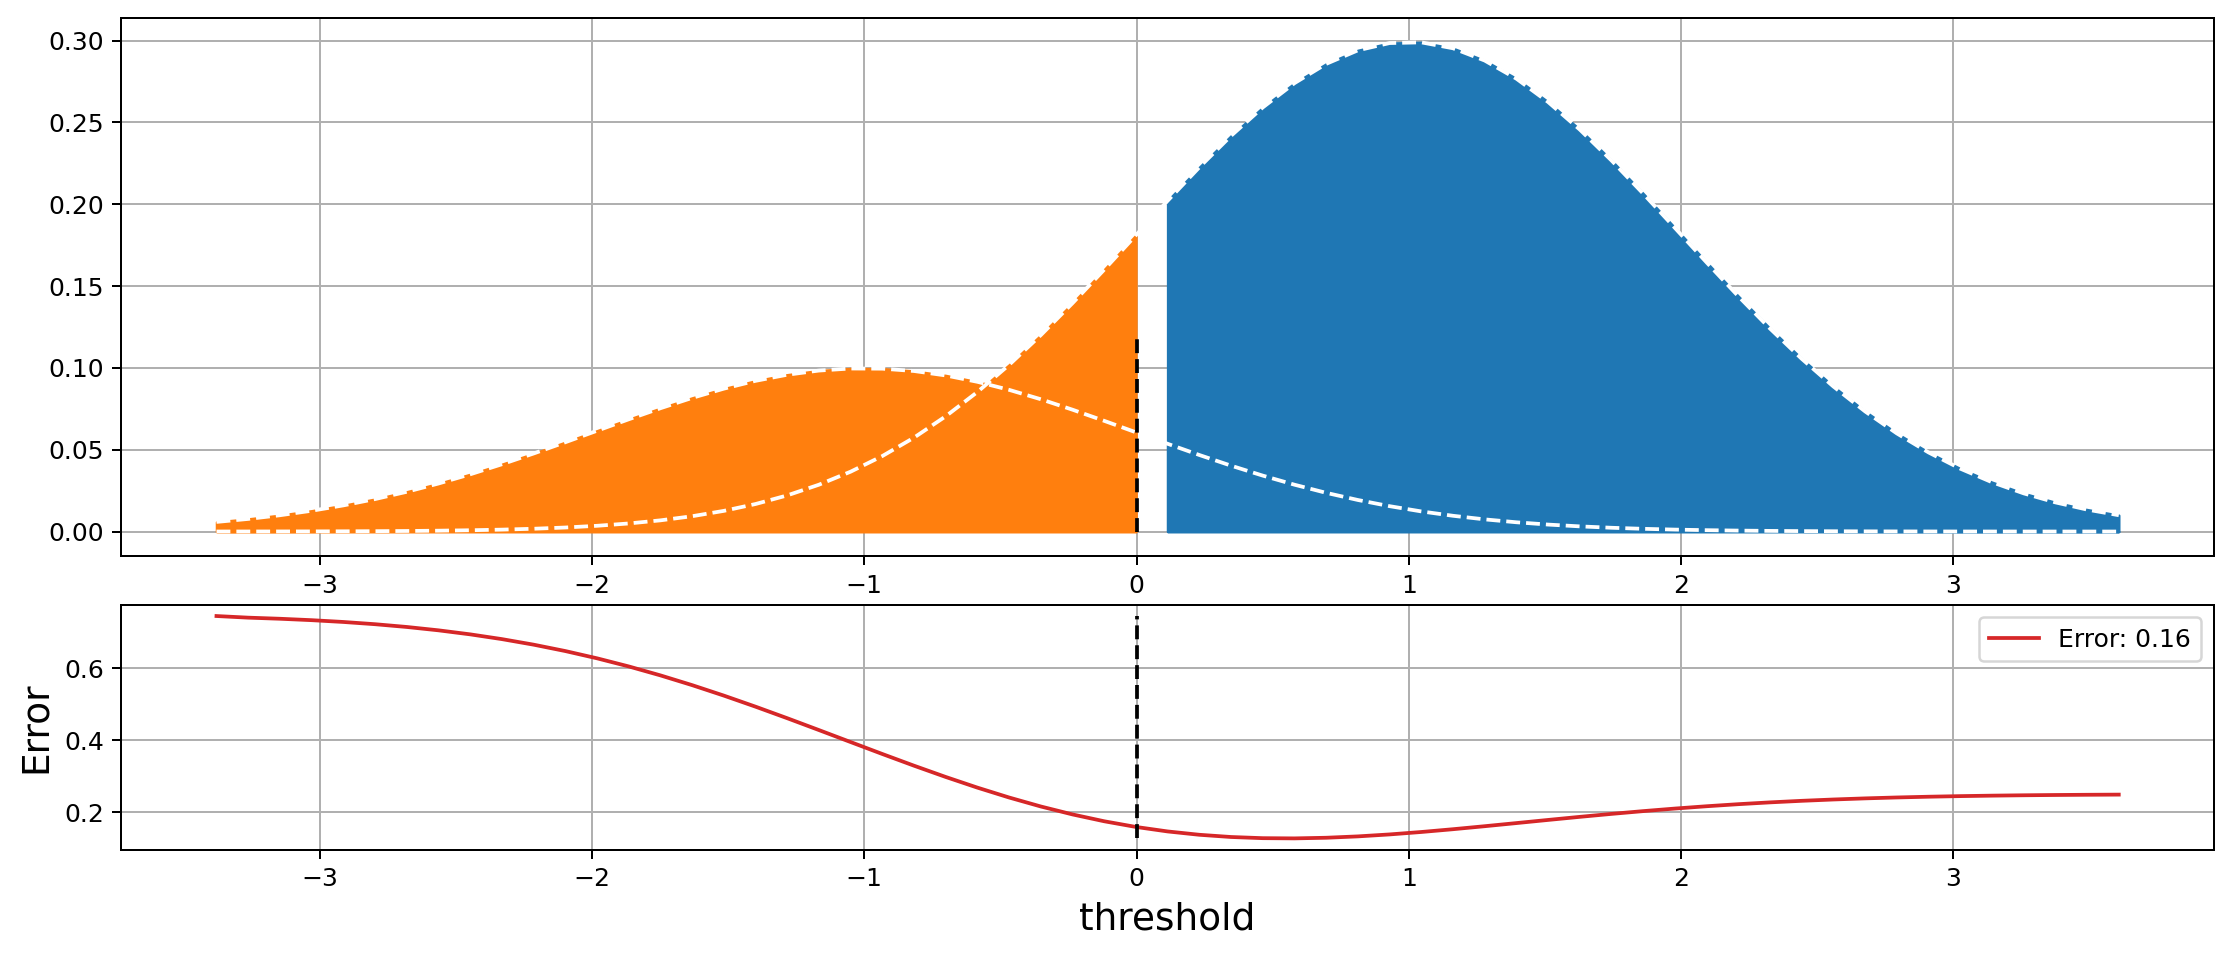

interactive(children=(FloatSlider(value=0.0, description='u', max=3.608249254456586, min=-3.379795352944334), …

In [ ]:
@interact(u=(umbral[0], umbral[-1], 0.1))
def umbral_interact(u=0):
    
    plt.figure()    
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.grid(True)
    
    plt.fill_between(y[y>u], y1[y>u], color='C0', zorder=90)
    plt.fill_between(y[y>u], y0[y>u], color='C0', zorder=90)
    
    plt.fill_between(y[y<u], y1[y<u], color='C1', zorder=90)
    plt.fill_between(y[y<u], y0[y<u], color='C1', zorder=90)
    
    plt.plot(y, y1, linestyle='--', color='w', zorder=99)
    plt.plot(y, y0, linestyle='--', color='w', zorder=99)
    
    plt.vlines(u, 0, 0.12, color='k', linestyle='--', zorder=100)
    
    plt.ylabel('')
    
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    plt.grid(True)

    xerror = np.linspace(y[0], y[-1], len(error))
    error_ = np.array(error)
    error_value = error[(abs(y-u)).argmin()]
    
    plt.plot(xerror, error_, color='C3', label=f'Error: {error_value:0.2f}')
    plt.vlines(u, error_.min(), error_.max(), color='k', linestyle='--')
    plt.legend()
    
    plt.ylabel('Error')
    plt.xlabel('threshold')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae869be4-fccf-425b-9969-dad6f89a7d44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>